In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
def random_choice(total_elements, chosen_elements):
    '''
    total_elements: total number of elements in the array
    chosen_elements: number of elements to be chosen
    '''
    a = np.zeros(total_elements)
    random_vector = np.random.rand(chosen_elements)
    random_vector = random_vector.round(2)
    random_vector = random_vector / random_vector.sum(axis=0, keepdims=1)
    a[:chosen_elements] = random_vector
    np.random.shuffle(a)
    return a
def random_choose_candidate(num_candidate,total_dim,non_zeros_dim): 
    '''
    num_candidate: number of candidate to be chosen
    total_candidate: total number of candidates
    chosen_elements: number of elements to be chosen
    '''
    # repeat the random_choice function for num_candidate times
    lower_bound = np.zeros(total_dim)
    upper_bound = np.ones(total_dim)
    a = np.zeros((num_candidate,total_dim))
    for i in range(num_candidate):
        while True:
            candidate = random_choice(total_dim,non_zeros_dim)
            if np.all((candidate >= lower_bound) & (candidate <= upper_bound)):
                a[i,:] = candidate
                break
    return a.round(2)
a= random_choose_candidate(96,96,3)
a.shape

(96, 96)

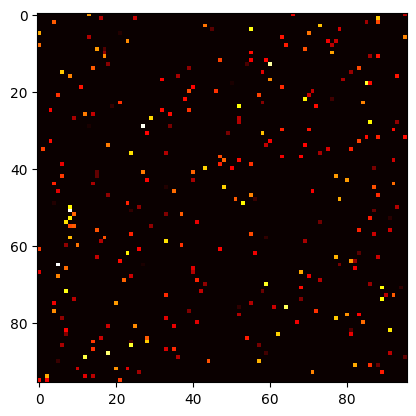

In [3]:
# read the data
positions = a
# turn the non-zero values into 1
#plot the heatmap
plt.imshow(positions, cmap='hot', interpolation='nearest')
plt.show()
# find the non-zero positions as (dest, source) pairs
non_zero_pos = np.argwhere(positions)

In [4]:
def calculate_distance(pos_matrix):
    # given a non-zero position matrix, calculate the distance between each pair
    distance_matrix = np.zeros((pos_matrix.shape[0], pos_matrix.shape[0]))
    for i in range(pos_matrix.shape[0]):
        for j in range(pos_matrix.shape[0]):
            is_neighbor_dest = ((pos_matrix[i, 0]//8) == (pos_matrix[j, 0]//8)) and ((abs(pos_matrix[i, 0] - pos_matrix[j, 0]) <=2) and (abs(pos_matrix[i, 0] - pos_matrix[j, 0])>0))
            is_neighbor_source = ((pos_matrix[i, 1]//8) == (pos_matrix[j, 1]//8)) and ((abs(pos_matrix[i, 1] - pos_matrix[j, 1]) <=2) and (abs(pos_matrix[i, 1] - pos_matrix[j, 1])>0))
            if is_neighbor_dest and is_neighbor_source:
                distance_matrix[i, j] = 0
            elif is_neighbor_dest or is_neighbor_source:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = 2
    distance_matrix = np.vstack((np.zeros(distance_matrix.shape[0]), distance_matrix))
    distance_matrix = np.hstack((np.zeros((distance_matrix.shape[0], 1)), distance_matrix))
    return distance_matrix

In [5]:
"""Capacited Vehicles Routing Problem (CVRP)."""

def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    demands = np.ones(distance_matrix.shape[0])
    demands[0] = 0
    data["demands"] = demands
    data["num_vehicles"] = (distance_matrix.shape[0]-1)//8+1
    data["vehicle_capacities"] = np.ones(data["num_vehicles"])*8
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    recorder = np.zeros((500,10))
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            if node_index != 0:
                recorder[vehicle_id,int(route_load)] = node_index
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")
    return total_distance,recorder

def CVRP_solver(distance_matrix):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        distance,recorder = print_solution(data, manager, routing, solution)
        return distance, recorder

In [6]:
def pair_distance_calculator(pos1,pos2):
    is_neighbor_dest = ((pos1[0]//8) == (pos2[0]//8)) and ((abs(pos1[0] - pos2[0]) <=2) and (abs(pos1[0] - pos2[0])>0))
    is_neighbor_source = ((pos1[1]//8) == (pos2[1]//8)) and ((abs(pos1[1] - pos2[1]) <=2) and (abs(pos1[1] - pos2[1])>0))
    if is_neighbor_dest and is_neighbor_source:
        return 0
    elif is_neighbor_dest or is_neighbor_source:
        return 1
    else:
        return 2

def distance_calculator(non_zero_pos):
    distance_sum = 0
    for i in range(non_zero_pos.shape[0]//8):
        # take the first 8 elements
        temp = non_zero_pos[i*8:(i+1)*8]
        temp_sum = 0
        for j in range(7):
            #print(temp[j],temp[j+1])
            temp_sum += pair_distance_calculator(temp[j],temp[j+1])
        #print(temp_sum)
        distance_sum += temp_sum
    
    return distance_sum


In [7]:
distance_matrix = calculate_distance(non_zero_pos)
distance_matrix
# take the lover triangle of the distance matrix
distance_matrix = np.tril(distance_matrix)
distance_matrix
# remove the upper triangle and save as a list


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 2., 2., ..., 0., 0., 0.],
       ...,
       [0., 2., 2., ..., 2., 0., 0.],
       [0., 2., 2., ..., 1., 2., 0.],
       [0., 2., 2., ..., 2., 2., 2.]])

In [8]:
# generate the .vrp file
# store the data as dictionary
metadata = {'NAME': 'random_96_vrp',
            'TYPE': 'CVRP',
            'COMMENT': 'VRP example',
            'DIMENSION': non_zero_pos.shape[0],
            'EDGE_WEIGHT_TYPE': 'EXPLICIT',
            'EDGE_WEIGHT_FORMAT': 'LOWER_DIAG_ROW',
            'EDGE_WEIGHT_SECTION': ''}

In [9]:
stat = []
for i in [4]:
    positions = random_choose_candidate(96,96,i)
    non_zero_pos = np.argwhere(positions)
    distance_matrix = calculate_distance(non_zero_pos)
    optimized_distance,recorder = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(non_zero_pos)
    stat.append((i,non_optimized_distance,optimized_distance))
stat = np.array(stat)
    

TypeError: 'numpy.float64' object cannot be interpreted as an integer

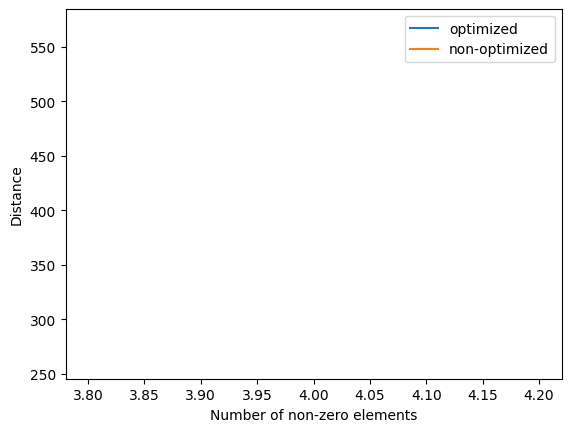

In [9]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='optimized')
plt.plot(stat[:,0],stat[:,2],label='non-optimized')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

In [10]:
stat

array([[  4, 569, 261]])

In [85]:
distance_sum = 0
for i in range(non_zero_pos.shape[0]//8):
    # take the first 8 elements
    temp = non_zero_pos[i*8:(i+1)*8]
    temp_sum = 0
    for j in range(7):
        print(temp[j],temp[j+1])
        temp_sum += pair_distance_calculator(temp[j],temp[j+1])
    print(temp_sum)
    distance_sum += temp_sum


[8 3] [  8 111]
[  8 111] [  8 153]
[  8 153] [  8 184]
[  8 184] [ 9 23]
[ 9 23] [ 9 38]
[ 9 38] [ 9 61]
[ 9 61] [ 9 90]
13
[10 22] [10 38]
[10 38] [ 10 146]
[ 10 146] [ 10 164]
[ 10 164] [11 21]
[11 21] [11 57]
[11 57] [ 11 111]
[ 11 111] [ 11 140]
13
[12 45] [12 63]
[12 63] [12 95]
[12 95] [ 12 105]
[ 12 105] [13  5]
[13  5] [13 29]
[13 29] [ 13 130]
[ 13 130] [ 13 154]
13
[14 76] [ 14 113]
[ 14 113] [ 14 184]
[ 14 184] [15 73]
[15 73] [ 15 108]
[ 15 108] [ 15 173]
[ 15 173] [16 76]
[16 76] [ 16 118]
13
[ 16 184] [17 72]
[17 72] [ 17 144]
[ 17 144] [ 17 187]
[ 17 187] [18 90]
[18 90] [ 18 118]
[ 18 118] [ 18 173]
[ 18 173] [ 18 186]
12
[19 76] [ 19 113]
[ 19 113] [ 19 184]
[ 19 184] [20 73]
[20 73] [ 20 135]
[ 20 135] [ 20 154]
[ 20 154] [21 18]
[21 18] [21 40]
12
[21 75] [ 21 111]
[ 21 111] [22 76]
[22 76] [22 81]
[22 81] [ 22 118]
[ 22 118] [ 22 186]
[ 22 186] [23 61]
[23 61] [ 23 184]
12
[24 76] [ 24 113]
[ 24 113] [ 24 184]
[ 24 184] [25 76]
[25 76] [ 25 160]
[ 25 160] [ 25 184]

In [23]:
non_zero_pos.shape

(381, 2)

In [26]:
recorder = recorder[~np.all(recorder == 0, axis=1)]
recorder = recorder[:, ~np.all(recorder == 0, axis=0)]
# Create a boolean mask that is True for rows containing any zero
mask = (recorder == 0).any(axis=1)
# Get the rows not containing zero and the rows containing zero
non_zero_rows = recorder[~mask]
zero_rows = recorder[mask]
# Concatenate the two arrays to get a new array where rows containing zero are at the end
recorder = np.concatenate([non_zero_rows, zero_rows])
print(recorder)
sorted_idx = recorder.flatten()
#remove the zero elements
sorted_idx = sorted_idx[sorted_idx != 0]-1
# arrange the non-zero elements in the order of the sorted index
sorted_non_zero_pos = non_zero_pos[sorted_idx.astype(int)]
print(sorted_non_zero_pos)

[[ 21.  16.  11.   8.  15.  10.  14.   7.]
 [ 29.  23.  20.  22.  19.  13.   9.  18.]
 [ 32.  28.  31.  26.  17.  25.  30.  24.]
 [ 39.  35.  38.  34.  37.  33.   3.  12.]
 [ 47.  44.  46.  42.  45.  41.  40.  36.]
 [ 61.  56.  51.  55.  49.  54.  48.  43.]
 [ 65.  52.  58.  63.  57.  50.  53.  62.]
 [ 71.  70.  68.  69.  66.  60.  64.  59.]
 [ 80.  73.  78.  75.  72.  67.  74.  77.]
 [ 88.  86.  82.  85.  76.  84.  81.  79.]
 [ 97.  91.  93.  90.  92.  89.  87.  83.]
 [105. 101. 104. 100.  96.  99.  98.  94.]
 [112. 108. 111. 107. 103.  95. 106. 102.]
 [118. 114. 110. 117. 113. 116. 109. 115.]
 [126. 122. 125. 120. 124. 121. 123. 119.]
 [135. 134. 130. 132. 129. 131. 127.  27.]
 [147. 142. 138. 141. 137. 133. 139. 136.]
 [152. 150. 146. 140. 145. 149. 144. 148.]
 [159. 143. 154. 158. 151. 157. 153. 155.]
 [169. 168. 165. 167. 160. 164. 162. 128.]
 [179. 174. 166. 173. 170. 171. 163. 161.]
 [187. 184. 176. 183. 181. 178. 180. 175.]
 [195. 191. 156. 172. 182. 190. 186. 189.]
 [204. 200.

In [29]:
sorted_non_zero_pos=sorted_non_zero_pos + 1
non_zero_pos = non_zero_pos + 1
np.savetxt('non_sorted_commands.csv', non_zero_pos, delimiter=',', fmt='%d')
np.savetxt('sorted_commands.csv', sorted_non_zero_pos, delimiter=',',fmt='%d')